---
# MNIST: Hand-written Digit Classification
---

[MNIST](https://en.wikipedia.org/wiki/MNIST_database) is a classic dataset in computer vision used for handwritten digit classification. Below, I experiment with several different machine learning approaches included, fully-connected neural networks, convolutional neural networks, and, most notably, vision transformers; I compare each architecture and their overall performance on the classification task. This project is done using PyTorch and GPU-accelerated using the Mac M1 chip.

## Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

## Loading MNIST
The `torchvision` module contains links to many standard datasets. We can load the MNIST dataset into a `Dataset` object as follows:

In [2]:
train_dataset = datasets.MNIST('./data', train=True, download=True,  # Downloads into a directory ../data
                               transform=transforms.ToTensor())
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, 
                                                             [int(len(train_dataset)*0.8), int(len(train_dataset)*0.2)], 
                                                             generator=torch.Generator().manual_seed(42))
test_dataset = datasets.MNIST('./data', train=False, download=False,  # No need to download again
                              transform=transforms.ToTensor())

## Exploring our Data

The `Dataset` object is an iterable where each element is a tuple of (input `Tensor`, target). Each image in the training set is a (1, 28, 28) image. In plain English, this means that all our training examples are 28 by 28 greyscale images.

In [ ]:
first_train, first_target = train_dataset[0]

print(f"Data type of training data: {type(first_train)}")
print(f"Size of training data point: {first_train.size()}")

We can also check how many data points we have in our training, validation, and test sets:

In [ ]:
print(f"Number of training points: {len(train_dataset)}")
print(f"Number of validation points: {len(valid_dataset)}")
print(f"Number of test points: {len(test_dataset)}")

We can convert images to numpy arrays and plot them with matplotlib:

In [ ]:
plt.imshow(train_dataset[0][0][0].numpy(), cmap='gray')

## Training Loop

We can define a function called `run_training_loop` which can be used to train our model, regardless of its architecture. It follows a standard training loop in PyTorch.

In [3]:
def run_training_loop(model, batch_size=32, n_epochs=10, lr=1e-3):
    """
    Run a training loop based on the input model and associated parameters
    
    Parameters:
        model: The input model to be trained
        batch_size: Number of training points to include in batch
        n_epochs: Number of epochs to train the model for
        lr: Learning rate used in Adam optimizer
        
    """
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
    
    device = "mps" if torch.backends.mps.is_available() else "cpu"
    model.to(device)

    # Choose Adam as the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Use the cross entropy loss function
    loss_fn = nn.CrossEntropyLoss()

    # store metrics
    train_loss_history = np.zeros([n_epochs, 1])
    valid_accuracy_history = np.zeros([n_epochs, 1])
    valid_loss_history = np.zeros([n_epochs, 1])

    for epoch in range(n_epochs):

        # Some layers, such as Dropout, behave differently during training
        model.train()

        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            
            data, target = data.to(device), target.to(device)

            # Erase accumulated gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(data)

            # Calculate loss
            loss = loss_fn(output, target)
            train_loss += loss.item()

            # Backward pass
            loss.backward()
            
            # Weight update
            optimizer.step()

        train_loss_history[epoch] = train_loss / len(train_loader.dataset)

        # Track loss each epoch
        print('Train Epoch: %d  Average loss: %.4f' %
              (epoch + 1,  train_loss_history[epoch]))

        # Putting layers like Dropout into evaluation mode
        model.eval()

        valid_loss = 0
        correct = 0

        # Turning off automatic differentiation
        with torch.no_grad():
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                valid_loss += loss_fn(output, target).item()  # Sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
                correct += pred.eq(target.view_as(pred)).sum().item()

        valid_loss_history[epoch] = valid_loss / len(valid_loader.dataset)
        valid_accuracy_history[epoch] = correct / len(valid_loader.dataset)

        print('Valid set: Average loss: %.4f, Accuracy: %d/%d (%.4f)\n' %
              (valid_loss_history[epoch], correct, len(valid_loader.dataset),
              100. * valid_accuracy_history[epoch]))
    
    return model, train_loss_history, valid_loss_history, valid_accuracy_history

## Testing
After selecting hyperparameters from the validation set, evaluate on the held-out test set (distinct from the validation set).

In [4]:
def test_performance(model, batch_size=32):
    """
    Test model performance on test dataset
    
    Parameters:
        model: The model to be tested
        batch_size: Number of training points to include in batch
    """
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

    # Putting layers like Dropout into evaluation mode
    model.eval()
    # Use the cross entropy loss function
    loss_fn = nn.CrossEntropyLoss()
    
    # Send model to appropriate device
    device = "mps" if torch.backends.mps.is_available() else "cpu"
    model.to(device)

    test_loss = 0
    correct = 0

    # Turning off automatic differentiation
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)

    print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
          (test_loss, correct, len(test_loader.dataset),
          100. * test_accuracy))
    return test_loss, test_accuracy

# Fully-connected Neural Network

We ignore the local structure of our 28 x 28 images in favor of their vector representation as 784 x 1 input vectors. Our first model has three linear layers and uses a ReLU activation between them.

In [ ]:
model = nn.Sequential(
    nn.Flatten(),  
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 62),
    nn.ReLU(),
    nn.Linear(62, 10),
)


In [ ]:
trained_model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(model, n_epochs=10)
test_performance(model)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(train_loss_history, label='train')
ax.plot(valid_loss_history, label='valid')
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Cross-Entropy Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.savefig("loss_curves_fcn.jpg", dpi=300)

## Convolutional Neural Network

The CNN below includes two convolutional layers with max pooling and batch normalization, followed by three fully-connected layers. Dropout layers are introduced to avoid overfitting the model to our training set.

In [5]:
model = nn.Sequential(
    nn.Conv2d(1, 6, 5), # (1, 28, 28) -> (6, 24, 24)
    nn.BatchNorm2d(num_features=6),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # (6, 24, 24) -> (6, 12, 12)
    nn.Conv2d(6, 16, 5), # (6, 12, 12) -> (16, 8, 8)
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # (16, 8, 8) -> (16, 4, 4)
    nn.Flatten(),
    nn.Linear(16 * 4 * 4, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.Dropout(p=0.1),
    nn.ReLU(),
    nn.Linear(84, 10),
)

Train Epoch: 1  Average loss: 0.0065
Valid set: Average loss: 0.0024, Accuracy: 11742/12000 (97.8500)

Train Epoch: 2  Average loss: 0.0021
Valid set: Average loss: 0.0018, Accuracy: 11778/12000 (98.1500)

Train Epoch: 3  Average loss: 0.0015
Valid set: Average loss: 0.0015, Accuracy: 11825/12000 (98.5417)

Train Epoch: 4  Average loss: 0.0012
Valid set: Average loss: 0.0022, Accuracy: 11747/12000 (97.8917)

Train Epoch: 5  Average loss: 0.0010
Valid set: Average loss: 0.0013, Accuracy: 11862/12000 (98.8500)

Train Epoch: 6  Average loss: 0.0008
Valid set: Average loss: 0.0014, Accuracy: 11842/12000 (98.6833)

Train Epoch: 7  Average loss: 0.0007
Valid set: Average loss: 0.0014, Accuracy: 11862/12000 (98.8500)

Train Epoch: 8  Average loss: 0.0007
Valid set: Average loss: 0.0016, Accuracy: 11832/12000 (98.6000)

Train Epoch: 9  Average loss: 0.0006
Valid set: Average loss: 0.0014, Accuracy: 11865/12000 (98.8750)

Train Epoch: 10  Average loss: 0.0004
Valid set: Average loss: 0.0014, Ac

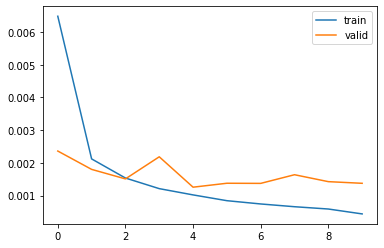

Test set: Average loss: 0.0014, Accuracy: 9894/10000 (98.9400)


(0.0014301540810701227, 0.9894)

In [6]:
trained_model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(model)
test_performance(model)

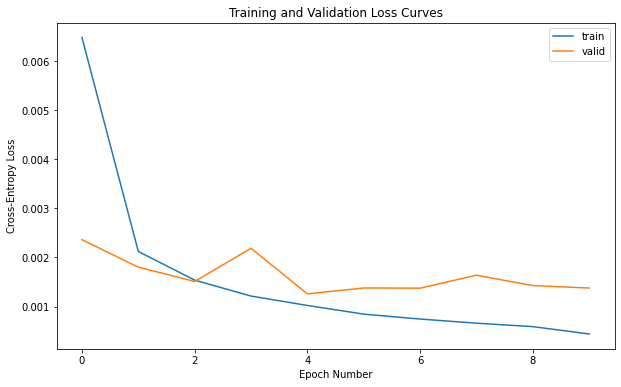

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(train_loss_history, label='train')
ax.plot(valid_loss_history, label='valid')
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Cross-Entropy Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.savefig("loss_curves_cnn.jpg", dpi=300)

## Vision Transformer

The Vision Transformer, oftentimes represented as ViT, is an achitecture introduced by the 2020 paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929). I wanted to see how such an architecture compares to the tried and true CNN at digit classification.

### Single-head Attention

A key component of the Vision Transformer is the self-attention mechanism. Described by the infamous paper entitled [Attention is All You Need ](https://arxiv.org/abs/1706.03762), we use **scaled dot-product attention** here.

In [ ]:
class SingleHeadAttention(nn.Module):
    def __init__(self, input_dim, inner_dim, dropout = 0.):
        super().__init__()
        self.Q = nn.Linear(input_dim, inner_dim, bias=False)
        self.K = nn.Linear(input_dim, inner_dim, bias=False)
        self.V = nn.Linear(input_dim, inner_dim, bias=False)
        self.softmax = nn.Softmax(dim=1)
        self.scale = 1 / np.sqrt(inner_dim)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        Q_proj = self.Q(x)
        K_proj = self.K(x)
        V_proj = self.V(x)

        K_T = K_proj.transpose(1, 2)
        QK_T = torch.matmul(Q_proj, K_T) * self.scale
        attention = self.softmax(QK_T)
        self.attention_cache = attention
        out = torch.matmul(attention, V_proj)
        out = self.dropout(out)

        return out

### Multi-head Attention

We can combine several attention-heads in parallel to create Multi-head Attention.

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        self.attention_heads = nn.ModuleList([
            SingleHeadAttention(dim, dim_head, dropout=dropout)
            for _ in range(heads)
        ])

    def forward(self, x):
        out = torch.cat([
            head(x) for head in self.attention_heads
        ], dim=-1)
        return out

### Vision Transformer Layer

We can abstract a single layer of the Vision Transformer as follows:

In [ ]:
class ViTLayer(nn.Module):
    def __init__(self, dim, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.attn = nn.Sequential(
            nn.LayerNorm(dim),
            Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
            nn.Dropout(p=dropout),
            nn.Linear(heads * dim_head, dim, bias=False)
        )
        self.feedforward = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, mlp_dim),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(p=dropout),
        )

    def forward(self, x):
        x = x + self.attn(x)
        x = x + self.feedforward(x)

        return x

### Putting it All Together: `ViT`

In [ ]:
class ViT(nn.Module):
    def __init__(self, patch_size=7, dim=64, depth=6, heads=8, mlp_dim=128, 
                 dim_head = 64,
                 dropout = 0., emb_dropout = 0.):
        super().__init__()

        image_height, image_width = 28, 28
        num_classes = 10
        channels = 1

        patch_height = patch_size
        patch_width = patch_size

        assert image_height % patch_height == 0 and image_width % patch_width == 0, (
            'Image dimensions must be divisible by the patch size.')

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.emb_dropout = nn.Dropout(emb_dropout)

        self.transformer = nn.Sequential(*nn.ModuleList([
            ViTLayer(dim, heads, dim_head, mlp_dim, dropout)
            for _ in range(depth)                       
        ]))

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.emb_dropout(x)

        x = self.transformer(x)

        x = x[:, 0]
        return self.mlp_head(x)

In [ ]:
model = ViT(patch_size=7, dim=64, depth=6, heads=8, mlp_dim=128)

In [ ]:
trained_model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(model)
test_performance(model)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(train_loss_history, label='train')
ax.plot(valid_loss_history, label='valid')
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Cross-Entropy Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.savefig("loss_curves_vit.jpg", dpi=300)

In [ ]:
torch.save(model.state_dict(), "ViT.pth")

## Looking at Attention Heads

By passing through data through our trained model, we can look at the attention heads and thus see where our model is focusing most of its attention.

In [ ]:
X, y = valid_dataset[0]

In [ ]:
plt.imshow(X.detach().numpy().squeeze(), cmap='gray')

In [ ]:
model(X.unsqueeze(0).to(device))

In [ ]:
heads = model.transformer[-1].attn[1].attention_heads

In [ ]:
heads[0].attention_cache.detach().cpu().numpy().squeeze()

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(8,4))

for i, (head, ax) in enumerate(zip(heads, axes.flatten()), 1):
    ax.imshow(head.attention_cache.detach().cpu().numpy().squeeze(), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(f"Head {i}")
    
plt.suptitle("Attention Heads (First Valid)");
plt.savefig("attention_heads.jpg", dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(train_loss_history, label='train')
ax.plot(valid_loss_history, label='valid')
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Cross-Entropy Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.savefig("loss_curves_q3c.jpg", dpi=300)